# Building your own recommender

This tutorial walks you through building your own recommender.
You will see how you can create resources in Amazon Personalize that generate personalized recommendations!

## Introduction to Amazon Personalize

Amazon Personalize is a fully managed machine learning service that makes it easy for developers to deliver personalized experiences to their users.

In Amazon Personalize, you start by creating a dataset group, which is a container for Amazon Personalize components. Your dataset group can be one of the following:

- A **Domain dataset group**, where you create preconfigured resources for `Video on Demand` or `E-commerce` usecases. You choose your business domain, import your data, and create recommenders.

- A **Custom dataset group**, where you create configurable resources for custom use cases. You choose a recipe, train a solution version (model), and deploy the solution version with a campaign. You use a campaign in your application to get recommendations.

Amazon Personalize can blend real-time user activity data with existing user profile and item information (historical data) to recommend the most relevant items for the user.

Personalize has different **Recipes** for different kind of use cases.

- **USER_PERSONALIZATION**: predict the items that a user will interact with based on Interactions, Items, and Users datasets. For personalized recommendation for each of your users, you should train your model with a USER_PERSONALIZATION recipe.

- **PERSONALIZED_RANKING**: Use this recipe when you’re personalizing the results for your users, such as personalized re-ranking of search results or curated lists.

- **RELATED_ITEMS**: return items similar to an item that you specify when you get recommendations. "You may also like" type of recommendations are usually based on this recipe. There are 2 types of related items recipes: 1) Similar-Items, 2) SIMS. To use Similar-Items, you must create an Interactions dataset and an Items dataset. If you don't have item metadata and want to recommend similar items, use the SIMS recipe recipe. If Amazon Personalize can't find the item ID that you specify in your recommendation request, the recipe returns popular items as recommendations.

- **USER_SEGMENTATION**: generate segments of users based on item input data. Useful for use cases such as generating a target marketing list for a specific course or item. There are two types: 1) Item-Affinity, 2) Item-Attribute-Affinity. The Item-Affinity creates a user segment for each item where as the Item-Attribute-Affinity creates a user segment for each item attribute that you specify

## Importing data

The minimum data requirements to train a model are:

- 1000 records of combined interaction data

- 25 unique users with at least 2 interactions each


Download the ratings.csv file (it is in your 4-personalized-recommendation folder) to your local and import to your S3 bucket (sagemaker-studio-*****). The dataset is about item rating by users. It contains user ID, item ID, rating (EVENT_VALUE) and timestamp. Objective is to build a recommender to recommend new items to users.

Custom dataset has a schema requirement as shown below.

**In this lab, we are only using interactions data, but you can also add users data and item data to make the recommendation model more effective**

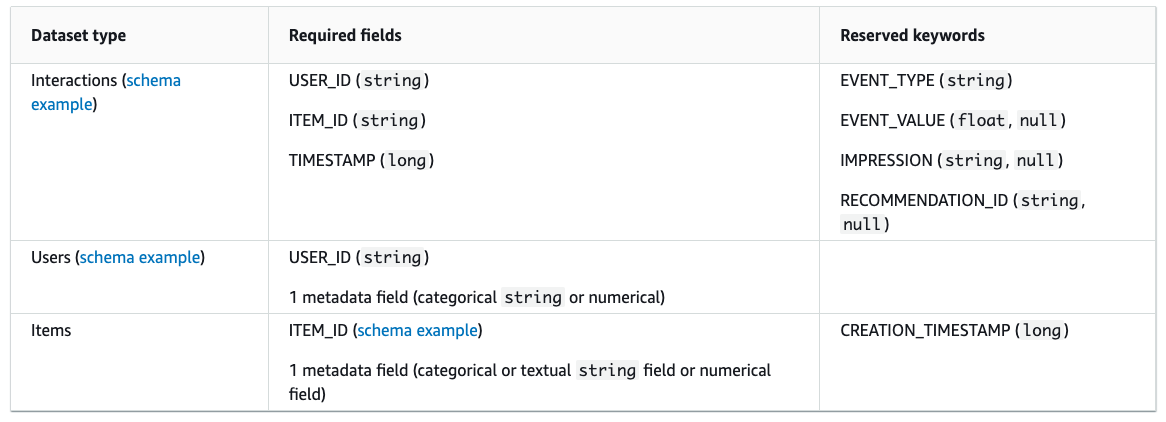

**Metadata fields**:

Metadata includes string or non-string fields that aren't required or don't use a reserved keyword. Metadata schemas have the following restrictions:

- Users and Items schemas require at least one metadata field.

- You can add at most *5 metadata fields for a Users schema and 50 metadata fields for an Items schema*.

Please note that *only Items schemas support fields with the textual attribute*. 

## Attaching a policy to your S3 bucket so that Amazon Personalize can access your S3 bucket

- Go to your S3 bucket, click on `Permissions`. Under **bucket policy**, click on `Edit`. Copy the below policy and paste it in the bucket policy section so that personalize is able to access your S3 bucket. **Remember to change the bucket name in the json policy under "Resource" to your unique S3 bucket name. Only copy the content starting the "{" till "}".**

```json
{
    "Version": "2012-10-17",
    "Id": "PersonalizeS3BucketAccessPolicy",
    "Statement": [
        {
            "Sid": "PersonalizeS3BucketAccessPolicy",
            "Effect": "Allow",
            "Principal": {
                "Service": "personalize.amazonaws.com"
            },
            "Action": [
                "s3:GetObject",
                "s3:ListBucket",
                "s3:PutObject",
                "s3:PutObjectAcl"
            ],
            "Resource": [
                "arn:aws:s3:::bucket-name",
                "arn:aws:s3:::bucket-name/*"
            ]
        }
    ]
}
```

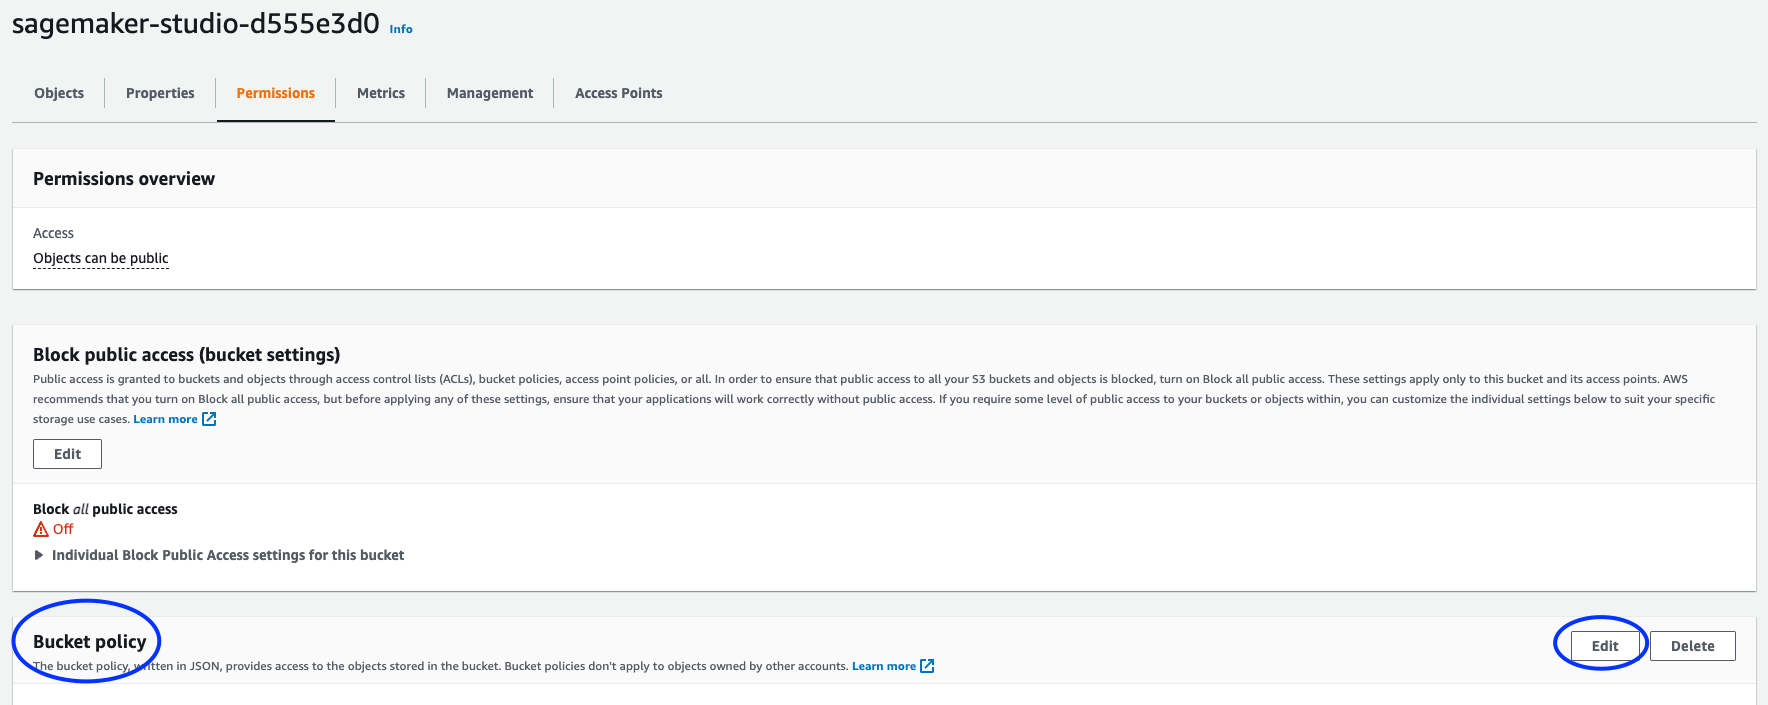

## Building the recommendation model using Amazon Personalize

- Go to **Personalize** console and click on **create dataset group**

- Give a name to the dataset group, under domain select **custom** and click **Create dataset group and continue**

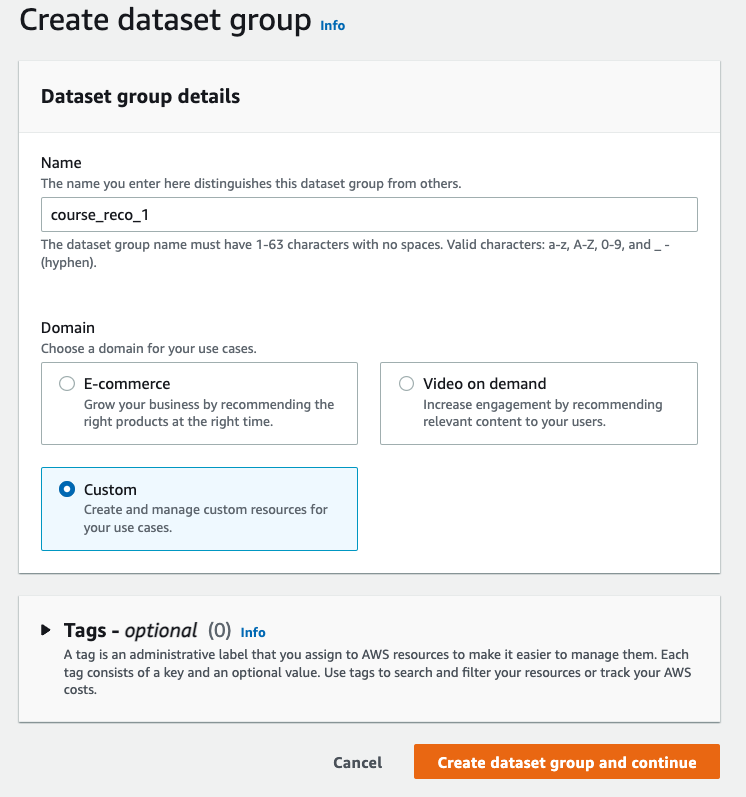

- Give a name to the dataset, select **Create new schema**, give a name to the schema such as "personalize-interaction" and paste the below schema in the **schema definition** portion. Then, click `Create dataset and continue`

`{
  "type": "record",
  "name": "Interactions",
  "namespace": "com.amazonaws.personalize.schema",
  "fields": [
    {
      "name": "USER_ID",
      "type": "string"
    },
    {
      "name": "ITEM_ID",
      "type": "string"
    },
    { "name": "EVENT_TYPE",
      "type": "string"
    },
    {
      "name": "EVENT_VALUE",
      "type": ["null", "float"]
    },
    {
      "name": "TIMESTAMP",
      "type": "long"
    }
  ],
  "version": "1.0"
}`

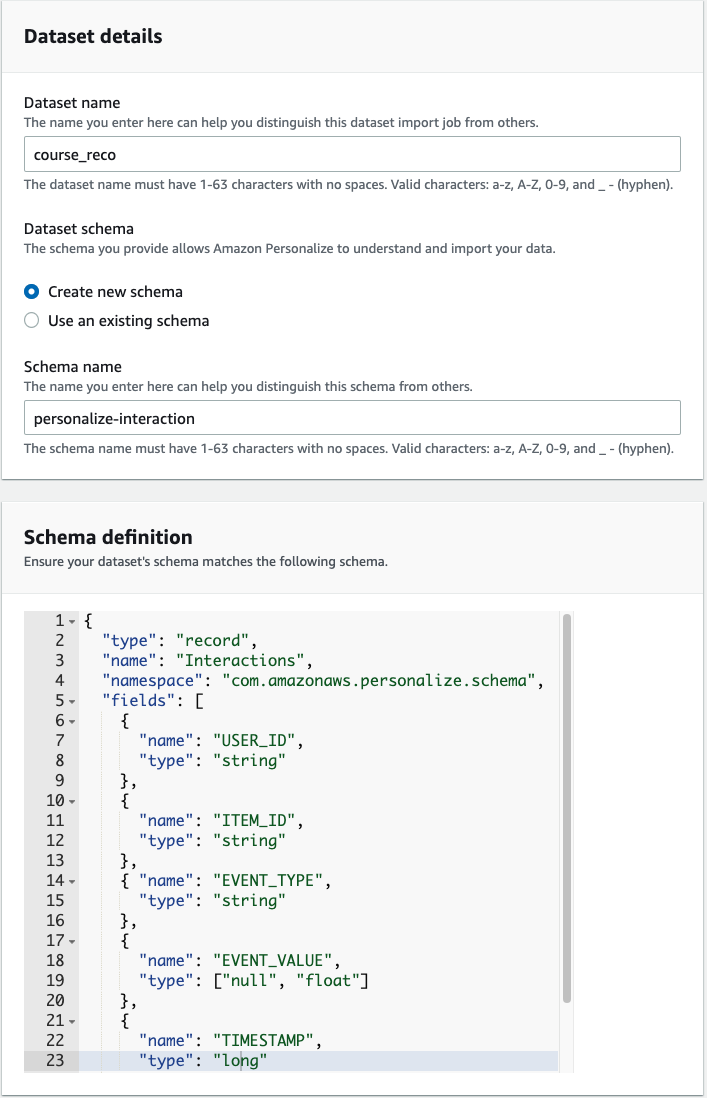

- **Default option for dataset import is S3**. Next, give a name to Dataset import job name.

- Copy the S3 URI for the file that you imported to S3 and paste in the **Data location**

- For the IAM role, create a new IAM role and select any S3 bucket, followed by click **Finish**.

After 1~2 min, you would see that interaction data is active as shown below.

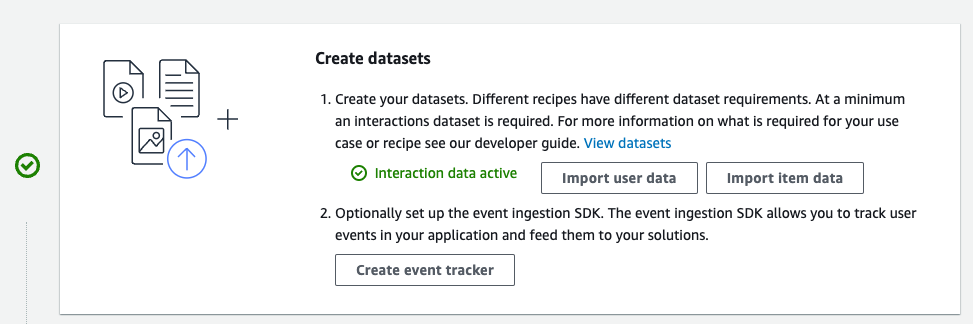

- Click on **Create solution**

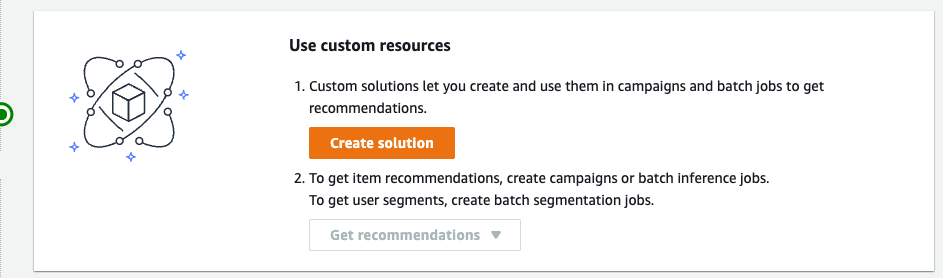

- Key-in a solution name, choose solution type as **item recommendation** and select recipe as **aws-user-personalization**

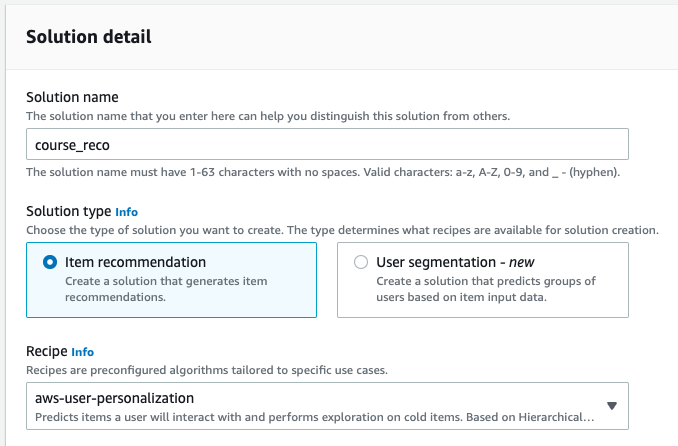

- Leave the **solution configuration** and **Advanced configuration** as default. Usually we will turn on **perform HPO** to find optimal hyperparameters for the ML model that Personalize will build. But, for this workshop, we will leave it blank as HPO optimization would take some time. Performing HPO is recommended so as to improve the model performance. Click on **Create and train solution**.

Now, under custom resources, select **solutions and recipes**, click on the **solution** that is created and you would see that solution version **Create in progress**

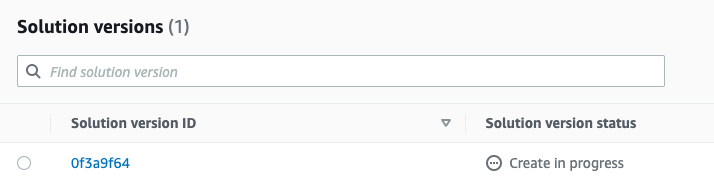

**It may take more than 40 min to train the model.**

**For remaining part of the workshop, you will not be able to do hands-on since training is not completed yet, but you can do it later in your own time.**

## Getting real time recommendation

Next step is to create **Campaign** if you want to do real time recommendation. You do not need to create campaigns if you are doing recommendation at batch. 

A campaign is a deployed solution version (trained model) with provisioned dedicated transaction capacity for creating real-time recommendations for your application users. After you create a campaign, you use the **GetRecommendations** or **GetPersonalizedRanking** API operations to get recommendations.

To create a campaign, select "campaigns" under "Custom Resources" and click `Create campaign`. 

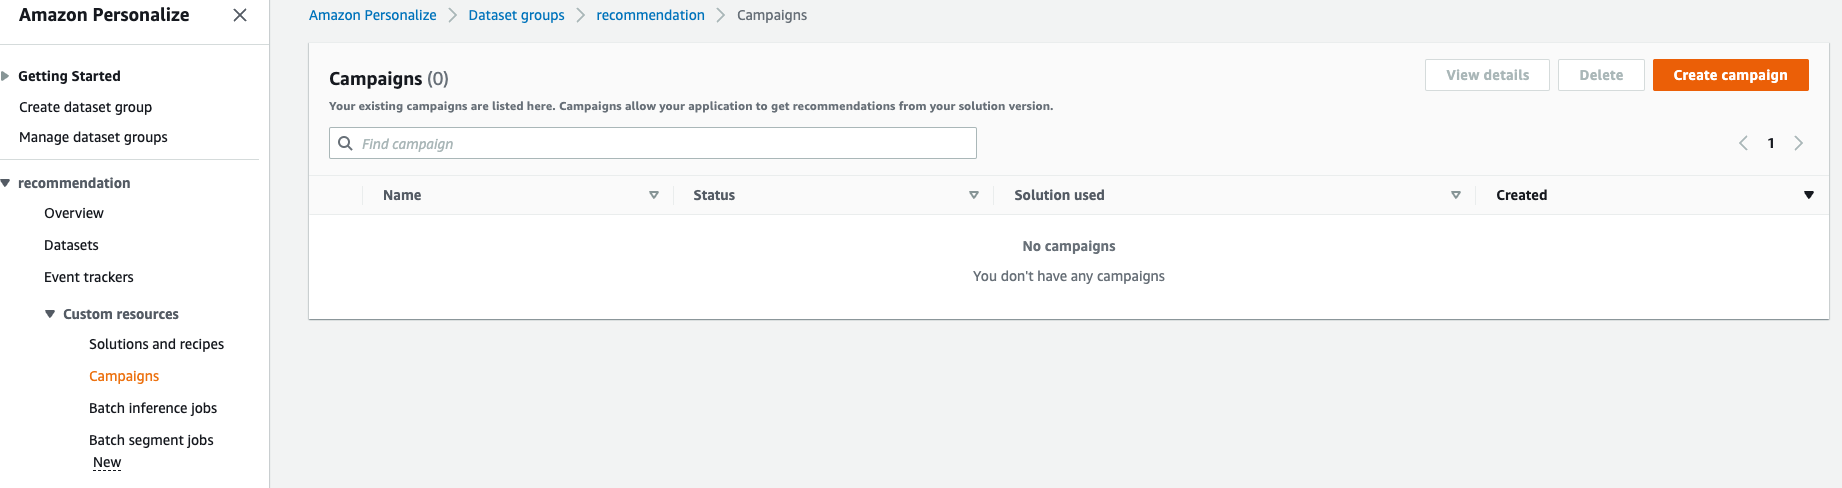

Give a name to the campaign, select the solution that you created earlier, the solution version ID will be selected automatically, leave the rest as default or you may change as per your need and then click `Create campaign`. 

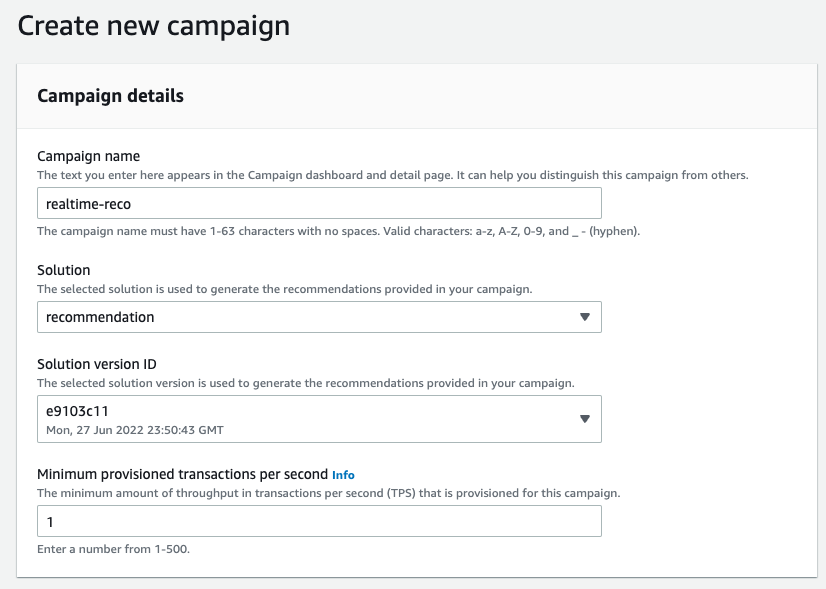

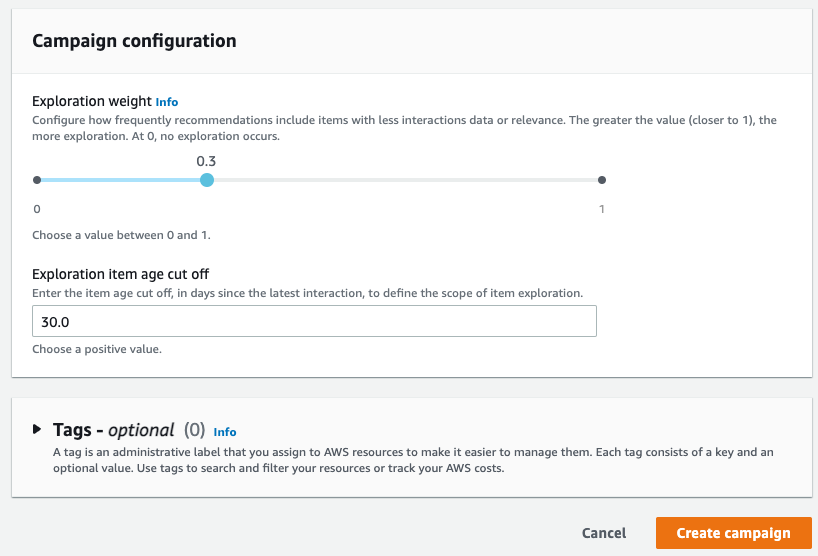

Once you create the campaign, you can test the real time recommendation in the console as shown below, by keying in a user ID and clicking on **Get recommendation**

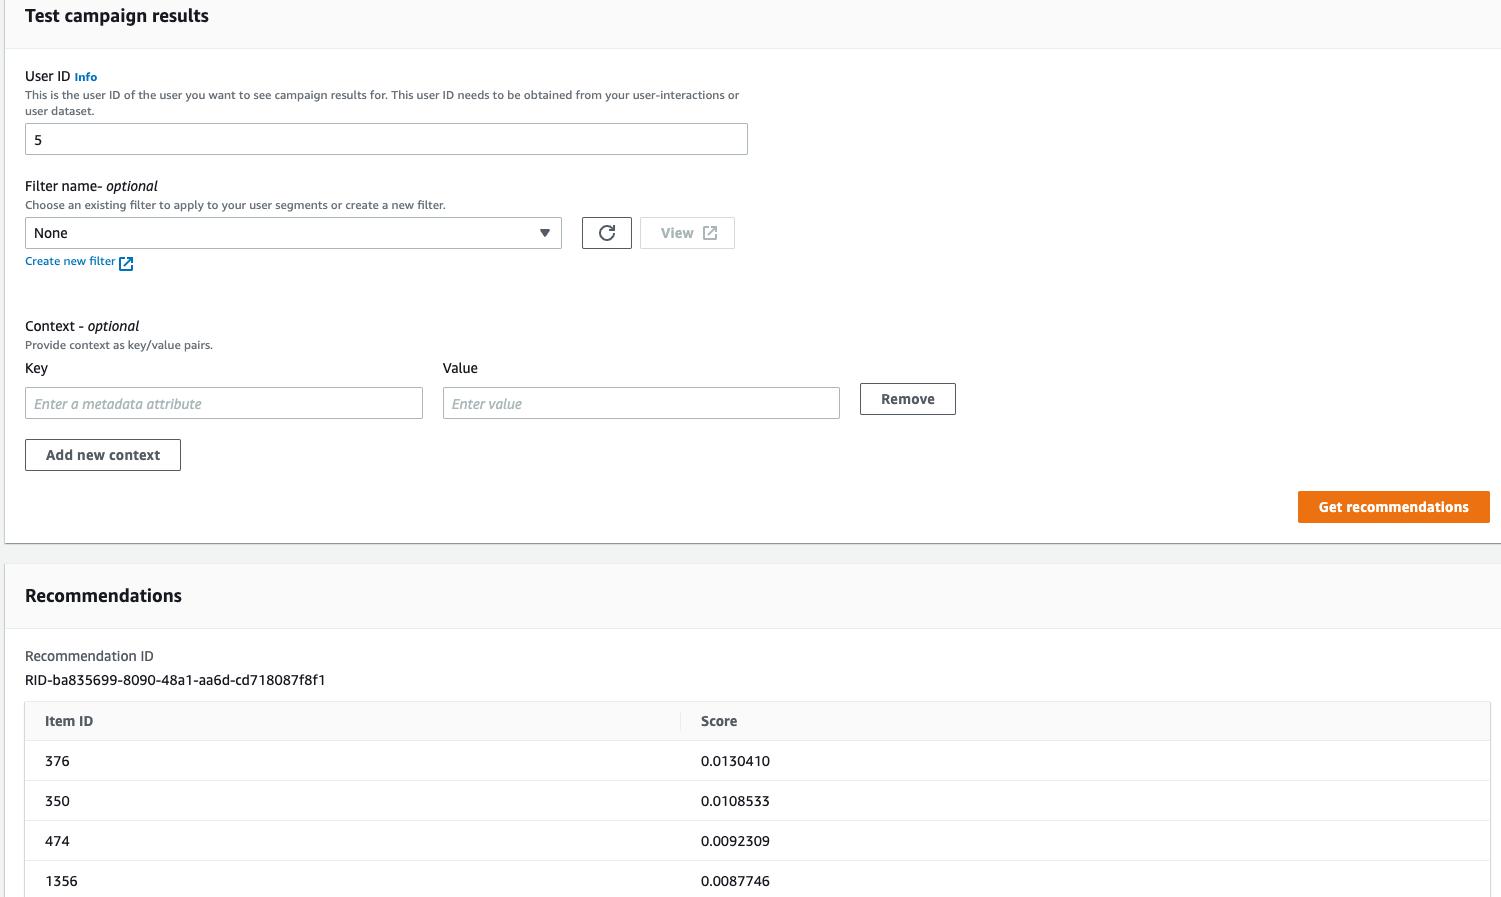

You can query the same recommendation using API as follows.

Before you can run the below cell, you will need SageMaker role to have access to Personalize. To do that, first go to SageMaker Studio, under control panel > Domain, you will see the Execution role. Copy the role after the "/". 

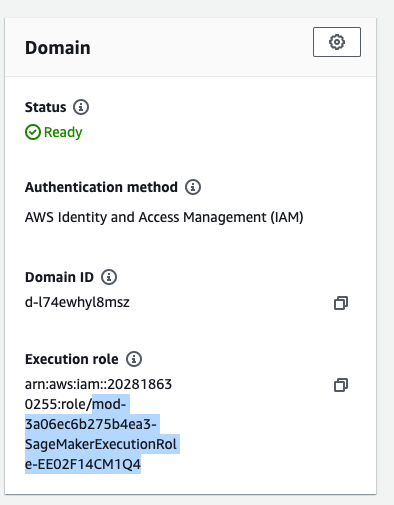

Now go to IAM, click on "roles", paste the role in the search bar and search for your sageMaker role. Next, click on the role > `add permissions` > `attach policies` > search for Personalize and select "AmazonPersonalizeFullAccess" > `Attach policies`

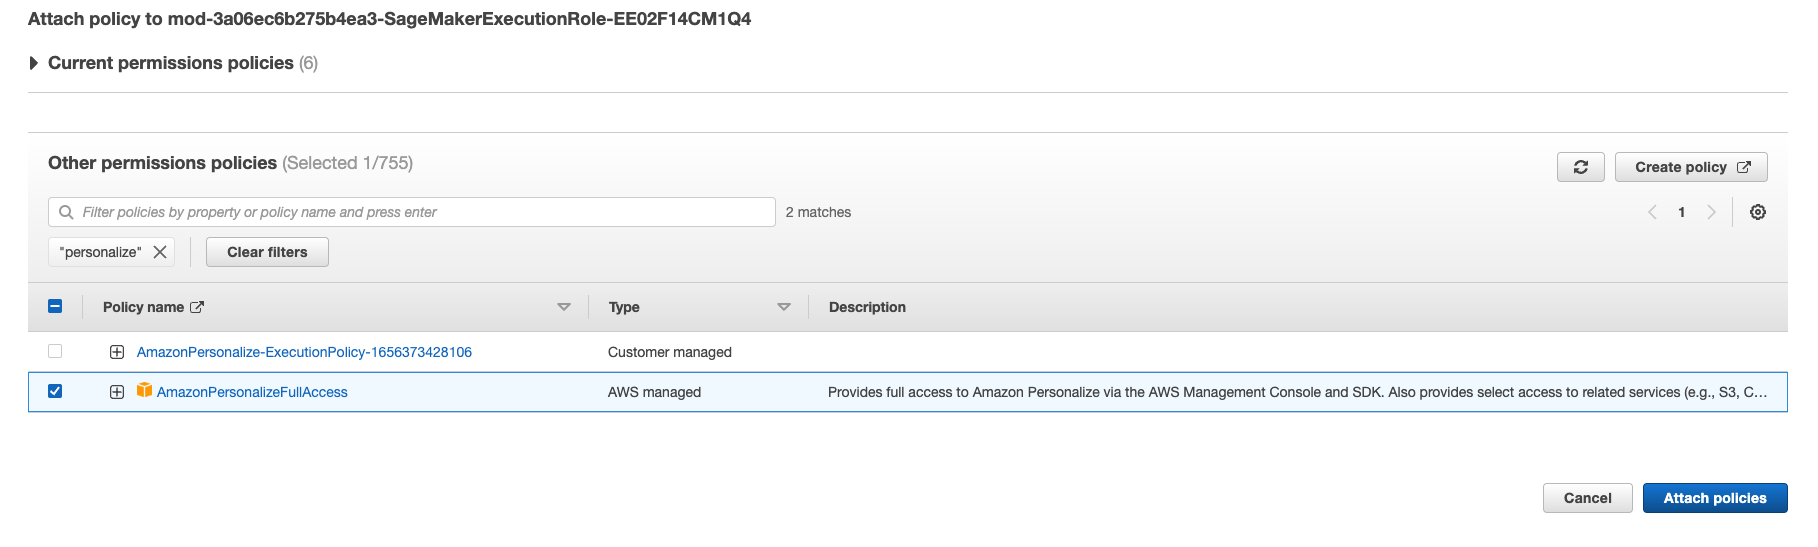

Now, run the below cell to get recommendation for a specific userID.

In [5]:
import boto3
import pprint
client = boto3.client('personalize-runtime')
response = client.get_recommendations(
    campaignArn='arn:aws:personalize:us-east-1:202818630255:campaign/realtime-reco',
    userId='5',
    numResults=4
)
pprint.pprint(response['itemList'])

[{'itemId': '368', 'score': 0.0678245},
 {'itemId': '333', 'score': 0.016827},
 {'itemId': '16', 'score': 0.0165632},
 {'itemId': '648', 'score': 0.0151542}]


## Getting batch recommendation

For batch inference, click on **Create batch inference job** under Batch inference jobs. 

- Under job detail, define the job name, create a new IAM role, select the solution from the drop-down and number of results that you want to see (optional).

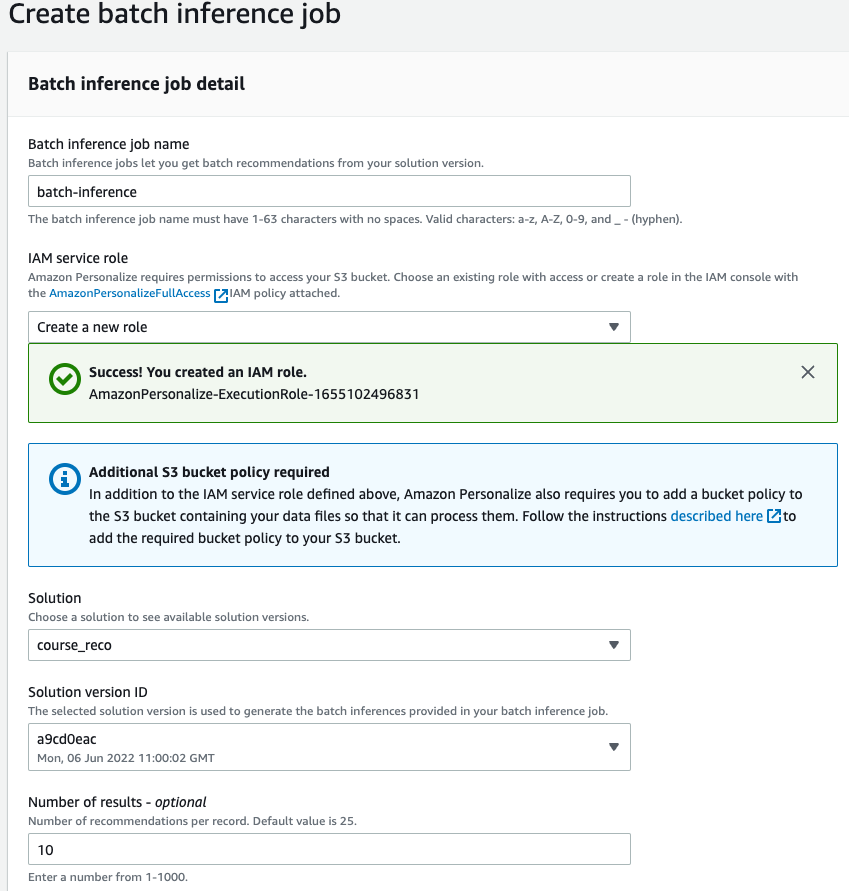

- Under **Batch inference job configuration**, you can choose the **exploration weight**, which determines how often you would want the model to recommend new items (with less interaction data) to customers. This is the classic **Exploration-Exploitation** trade-off in Machine Learning.

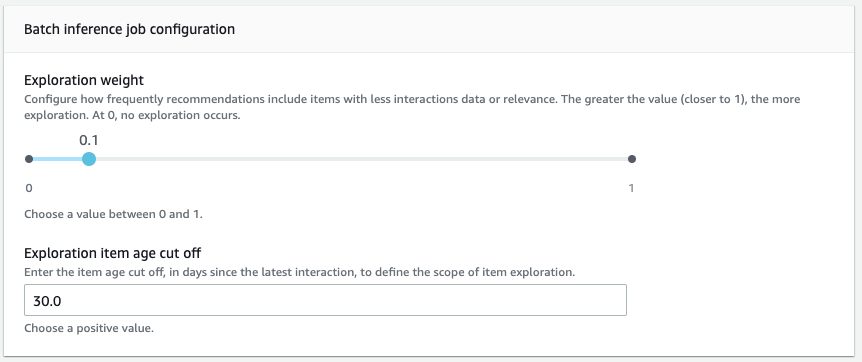

- Next step is to define the input batch data. Batch data needs to be formatted in a specific way as shown below, in json format. 

Upload the json file (personalize_test.json) in the S3 bucket. The json file looks like below.

Create a new folder to store the output results and provide the S3 URI path under *S3 output path*. Next, click on **Create batch inference job**

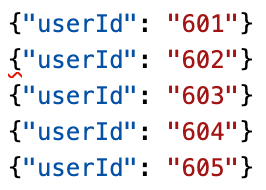

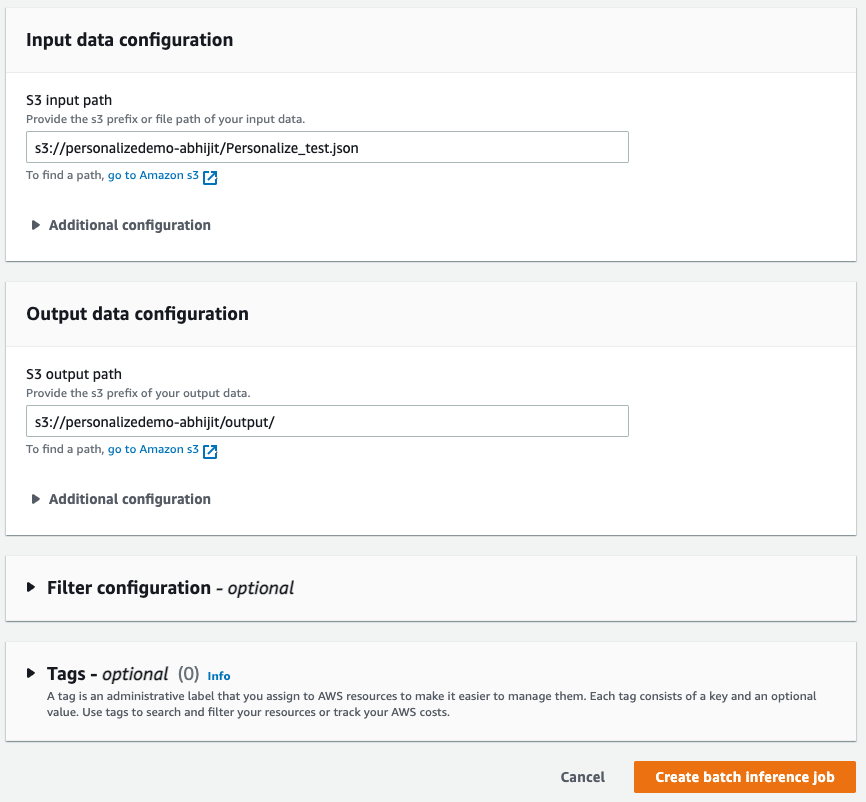

Once batch inference job is over, you will see the output in S3. The output would look like below. 

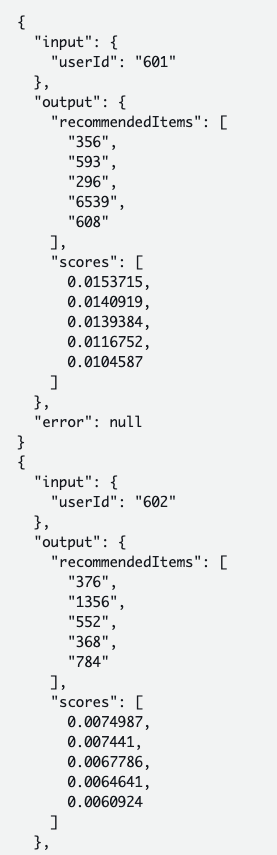

You can also create a batch inference job using API as shown below. The input parameters are the same as creating through console.

In [6]:
import boto3

personalize_rec = boto3.client(service_name='personalize')

personalize_rec.create_batch_inference_job (
    solutionVersionArn = "arn:aws:personalize:us-east-1:202818630255:solution/recommendation/e9103c11",
    jobName = "batch-reco2",
    roleArn = "arn:aws:iam::202818630255:role/service-role/AmazonPersonalize-ExecutionRole-1656381503256",
    batchInferenceJobConfig = {
        # optional USER_PERSONALIZATION recipe hyperparameters
        "itemExplorationConfig": {      
            "explorationWeight": "0.3",
            "explorationItemAgeCutOff": "30"
        }
    },
    jobInput = 
       {"s3DataSource": {"path": "s3://sagemaker-studio-d555e3d0/Personalize_test.json"}},
    jobOutput = 
       {"s3DataDestination": {"path": "s3://sagemaker-studio-d555e3d0/batch-inference-output2/"}}
)

CPU times: user 21.2 ms, sys: 0 ns, total: 21.2 ms
Wall time: 431 ms


{'batchInferenceJobArn': 'arn:aws:personalize:us-east-1:202818630255:batch-inference-job/batch-reco2',
 'ResponseMetadata': {'RequestId': '66715e48-fbfd-4890-b7ee-75a18631c9f7',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Tue, 28 Jun 2022 05:32:32 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '101',
   'connection': 'keep-alive',
   'x-amzn-requestid': '66715e48-fbfd-4890-b7ee-75a18631c9f7'},
  'RetryAttempts': 0}}

## Automatic Updates

With User-Personalization, Amazon Personalize automatically updates the latest model (solution version) every two hours behind the scenes to include new data without creating a new solution version. 

With each update, Amazon Personalize updates the solution version with the latest item information and adjusts the exploration according to implicit feedback from users. 

## Real-time Events Feedback to Model

To get real-time events from users and feedback to the model, you need the following:

- A dataset group that includes an Interactions dataset

- An event tracker

- A call to the "PutEvents" API.

More details [here](https://docs.aws.amazon.com/personalize/latest/dg/recording-events.html)